In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import IPython

In [148]:
df = pd.read_parquet('../final_data/final_data_v1.parquet').drop(['timestamp','location','lon','lat'],axis=1)
df_P0 = df.drop(['P1','P2'],axis=1)
df_P1 = df.drop(['P0','P2'],axis=1)
df_P2 = df.drop(['P1','P0'],axis=1)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df_p0 = df[0:int(n*0.7)].drop(['P1','P2'],axis=1)
val_df_p0 = df[int(n*0.7):int(n*0.9)].drop(['P1','P2'],axis=1)
test_df_p0 = df[int(n*0.9):].drop(['P1','P2'],axis=1)

train_df_p1 = df[0:int(n*0.7)].drop(['P0','P2'],axis=1)
val_df_p1 = df[int(n*0.7):int(n*0.9)].drop(['P0','P2'],axis=1)
test_df_p1 = df[int(n*0.9):].drop(['P0','P2'],axis=1)

train_df_p2 = df[0:int(n*0.7)].drop(['P1','P0'],axis=1)
val_df_p2 = df[int(n*0.7):int(n*0.9)].drop(['P1','P0'],axis=1)
test_df_p2 = df[int(n*0.9):].drop(['P1','P0'],axis=1)

print(train_df_p0)

       humidity  temperature     P0   Day sin  Year sin
50407      63.7         25.1   7.00  0.594823  0.948590
50412      63.1         24.5   7.00  0.584250  0.948579
67637      64.3         25.3   4.00  0.354291  0.895866
67642      63.2         25.6   3.00  0.346117  0.895856
67647      66.8         24.8   3.40  0.333807  0.895840
...         ...          ...    ...       ...       ...
17617      47.0         23.6  14.75 -0.923880  0.929294
17621      47.3         23.6  14.40 -0.928810  0.929307
17628      47.9         23.5  16.00 -0.938191  0.929334
17632      48.2         23.4  17.50 -0.941176  0.929342
17641      48.8         23.3  13.60 -0.949699  0.929369

[928891 rows x 5 columns]


In [149]:
train_mean_p0 = train_df_p0.mean()
train_std_p0 = train_df_p0.std()

train_df_p0 = (train_df_p0 - train_mean_p0) / train_std_p0
val_df_p0 = (val_df_p0 - train_mean_p0) / train_std_p0
test_df_p0 = (test_df_p0 - train_mean_p0) / train_std_p0

train_mean_p1 = train_df_p1.mean()
train_std_p1 = train_df_p1.std()

train_df_p1 = (train_df_p1 - train_mean_p1) / train_std_p1
val_df_p1 = (val_df_p1 - train_mean_p1) / train_std_p1
test_df_p1 = (test_df_p1 - train_mean_p1) / train_std_p1

train_mean_p2 = train_df_p2.mean()
train_std_p2 = train_df_p2.std()

train_df_p2 = (train_df_p2 - train_mean_p2) / train_std_p2
val_df_p2 = (val_df_p2 - train_mean_p2) / train_std_p2
test_df_p2 = (test_df_p2 - train_mean_p2) / train_std_p2



       humidity  temperature        P0   Day sin  Year sin
50407 -0.870579     1.059432 -0.513441  0.820273  1.488963
50412 -0.902885     0.900828 -0.513441  0.805353  1.488947
67637 -0.838274     1.112300 -0.600542  0.480856  1.414131
67642 -0.897501     1.191601 -0.629576  0.469322  1.414116
67647 -0.703667     0.980130 -0.617962  0.451951  1.414093
...         ...          ...       ...       ...       ...
10152  0.082434     1.535242 -0.165039  0.925129  1.349431
10215  0.017823     1.297337 -0.252139  0.825214  1.349244
10269 -0.062941     1.270903 -0.136005  0.739101  1.349092
10294 -0.149089     1.376639 -0.252139  0.697105  1.349020
10305 -0.186779     1.429507 -0.048904  0.675776  1.348985

[1326988 rows x 5 columns]


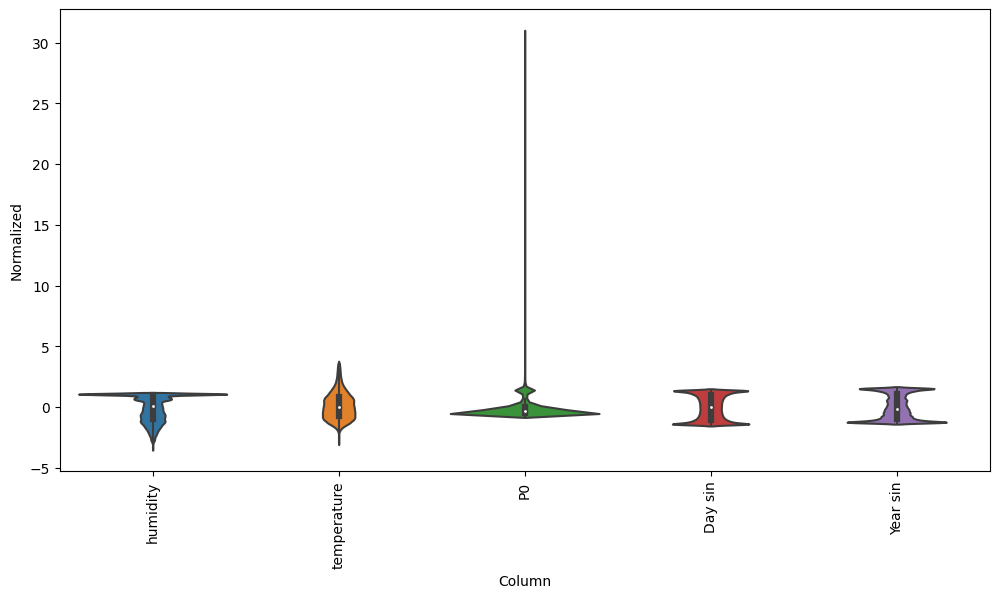

In [151]:
df_std_p0 = (df_P0 - train_mean_p0) / train_std_p0
print(df_std_p0)
df_std_p0 = df_std_p0.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_p0)
_ = ax.set_xticklabels(df_P0.keys(), rotation=90)

In [152]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [153]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1, train_df=train_df_p0, val_df=val_df_p0,test_df=test_df_p0,label_columns=['P0'])
print(w1)

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['P0']


In [154]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [155]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df_p0[:w1.total_window_size]),
                           np.array(train_df_p0[100:100+w1.total_window_size]),
                           np.array(train_df_p0[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
Labels shape: (3, 1, 1)


In [156]:
w1.example = example_inputs, example_labels

In [157]:
def plot(self, model=None, plot_col='P0', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

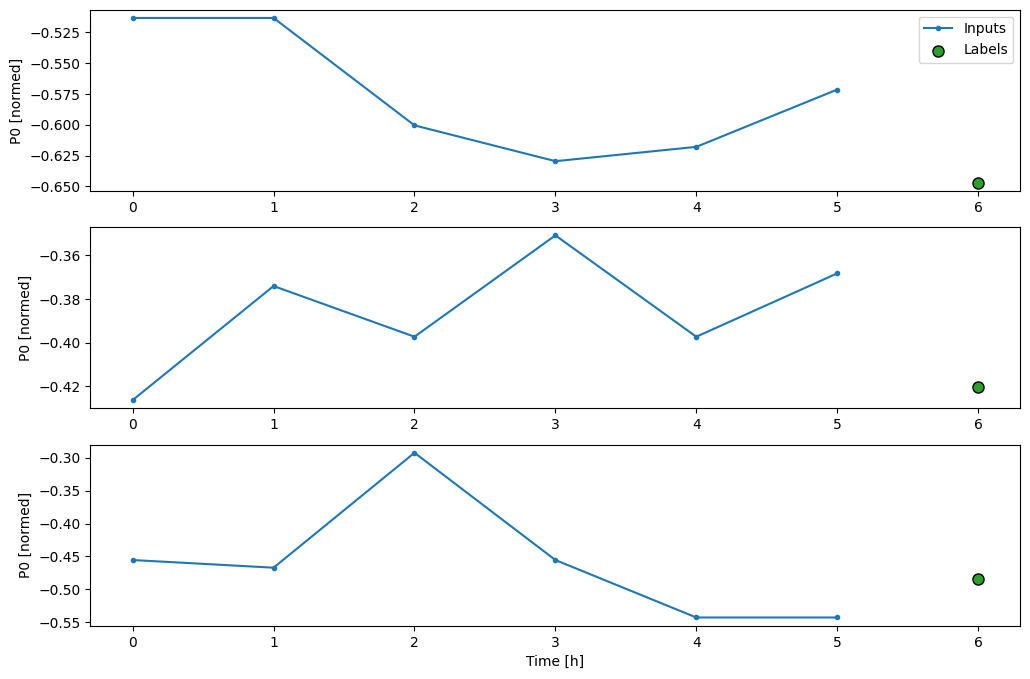

In [158]:
w1.plot()

In [159]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [160]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [161]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [162]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [163]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['P0'], train_df=train_df_p0,val_df=val_df_p0,test_df=test_df_p0)
print(single_step_window)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['P0']


In [164]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [165]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [166]:
baseline = Baseline(label_index=column_indices['P0'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8294/8294 [==============================] - 12s 1ms/step - loss: 1.5249 - mean_absolute_error: 1.0423


In [167]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, train_df=train_df_p0,val_df=val_df_p0,test_df=test_df_p0,label_columns=['P0'])

print(wide_window)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['P0']


In [168]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [169]:
# inputs, labels = wide_window.example
# prediction = baseline(inputs)
# print(prediction)
# plt.scatter(wide_window.label_indices,prediction[1, :, wide_window.label_columns_indices.get('P0', None)])

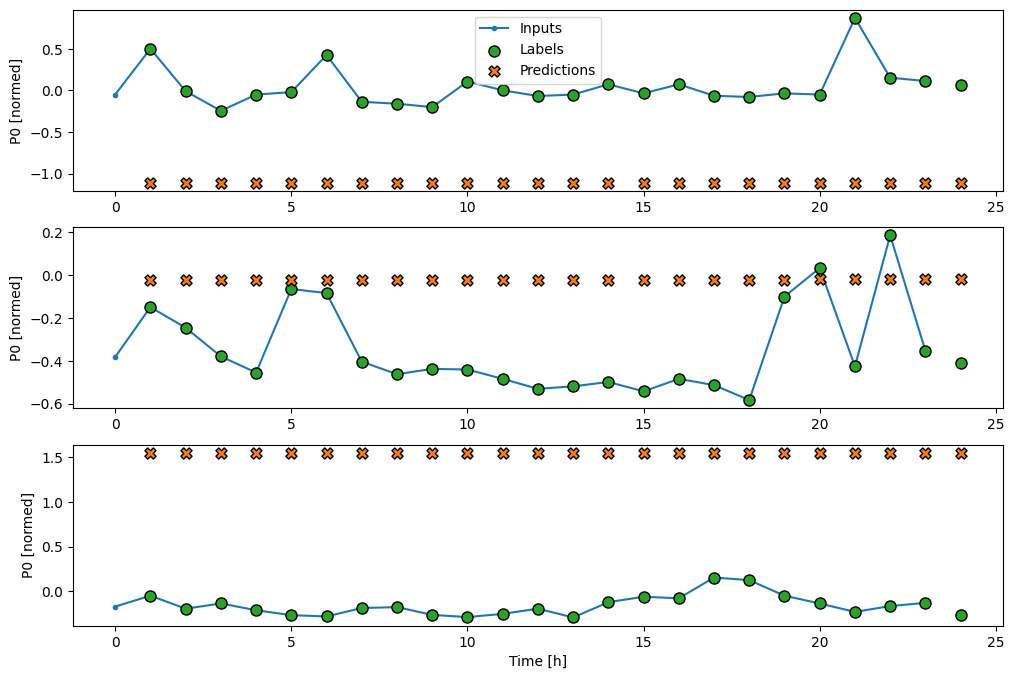

In [170]:
wide_window.plot(baseline)

# Linear Model

In [171]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [172]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [173]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [174]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
29028/29028 [==============================] - 51s 2ms/step - loss: 0.0768 - mean_absolute_error: 0.1067 - val_loss: 0.0460 - val_mean_absolute_error: 0.1043
Epoch 2/20
29028/29028 [==============================] - 49s 2ms/step - loss: 0.0565 - mean_absolute_error: 0.0886 - val_loss: 0.0460 - val_mean_absolute_error: 0.1044
Epoch 3/20
29028/29028 [==============================] - 51s 2ms/step - loss: 0.0565 - mean_absolute_error: 0.0886 - val_loss: 0.0459 - val_mean_absolute_error: 0.1043
Epoch 4/20
29028/29028 [==============================] - 48s 2ms/step - loss: 0.0565 - mean_absolute_error: 0.0886 - val_loss: 0.0459 - val_mean_absolute_error: 0.1044
Epoch 5/20
29028/29028 [==============================] - 49s 2ms/step - loss: 0.0565 - mean_absolute_error: 0.0886 - val_loss: 0.0460 - val_mean_absolute_error: 0.1043
Epoch 6/20
29028/29028 [==============================] - 43s 1ms/step - loss: 0.0565 - mean_absolute_error: 0.0886 - val_loss: 0.0459 - val_mean_absolute_

In [175]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


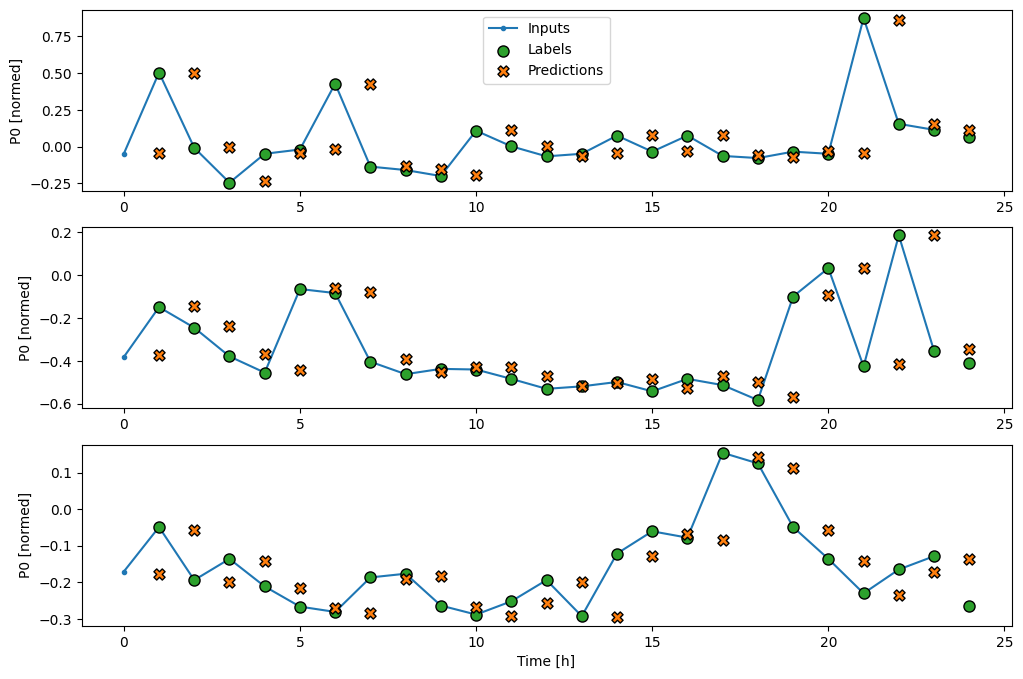

In [176]:
wide_window.plot(linear)

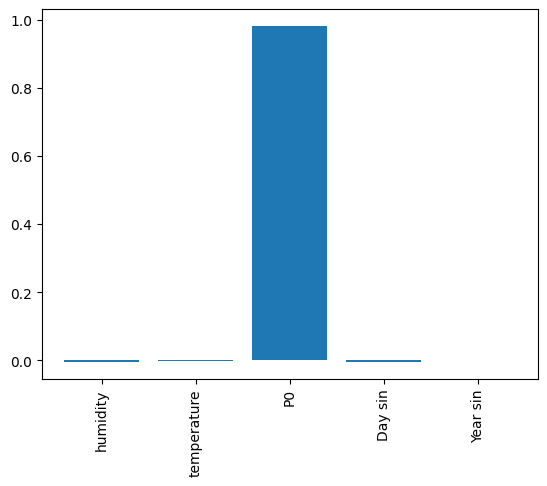

In [177]:
plt.bar(x = range(len(train_df_p0.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_p0.columns)))
_ = axis.set_xticklabels(train_df_p0.columns, rotation=90)

In [178]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
29028/29028 [==============================] - 57s 2ms/step - loss: 0.0557 - mean_absolute_error: 0.0974 - val_loss: 0.0424 - val_mean_absolute_error: 0.1045
Epoch 2/20
29028/29028 [==============================] - 61s 2ms/step - loss: 0.0479 - mean_absolute_error: 0.0910 - val_loss: 0.0418 - val_mean_absolute_error: 0.1065
Epoch 3/20
29028/29028 [==============================] - 59s 2ms/step - loss: 0.0467 - mean_absolute_error: 0.0898 - val_loss: 0.0421 - val_mean_absolute_error: 0.1043
Epoch 4/20
8294/8294 [==============================] - 11s 1ms/step - loss: 0.0418 - mean_absolute_error: 0.1050


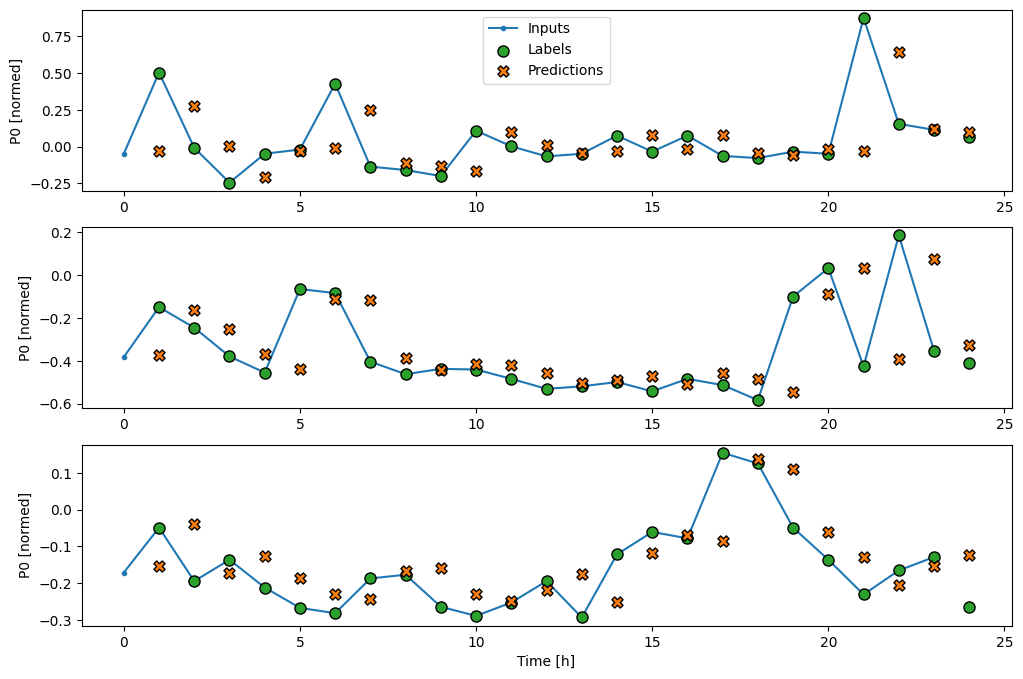

In [184]:
wide_window.plot(dense)

In [181]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['P0'],
    train_df=train_df_p0,
    val_df=val_df_p0,
    test_df=test_df_p0)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['P0']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

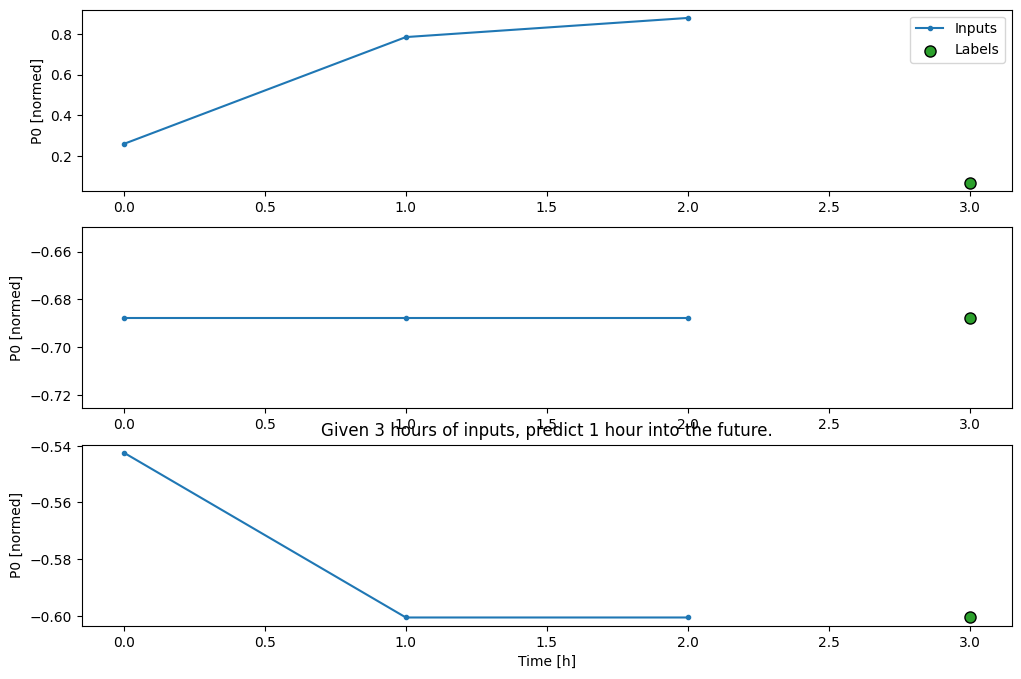

In [182]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [185]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [187]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


In [188]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

8294/8294 [==============================] - 11s 1ms/step - loss: 0.0342 - mean_absolute_error: 0.0942


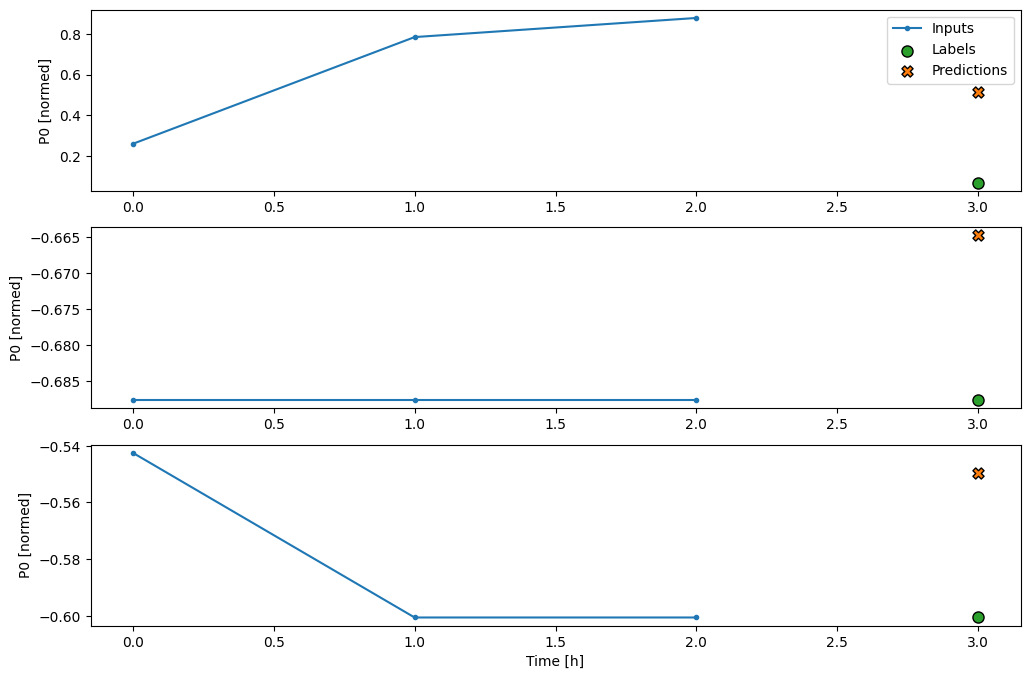

In [189]:
conv_window.plot(multi_step_dense)


# Modeles multi-étapes

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

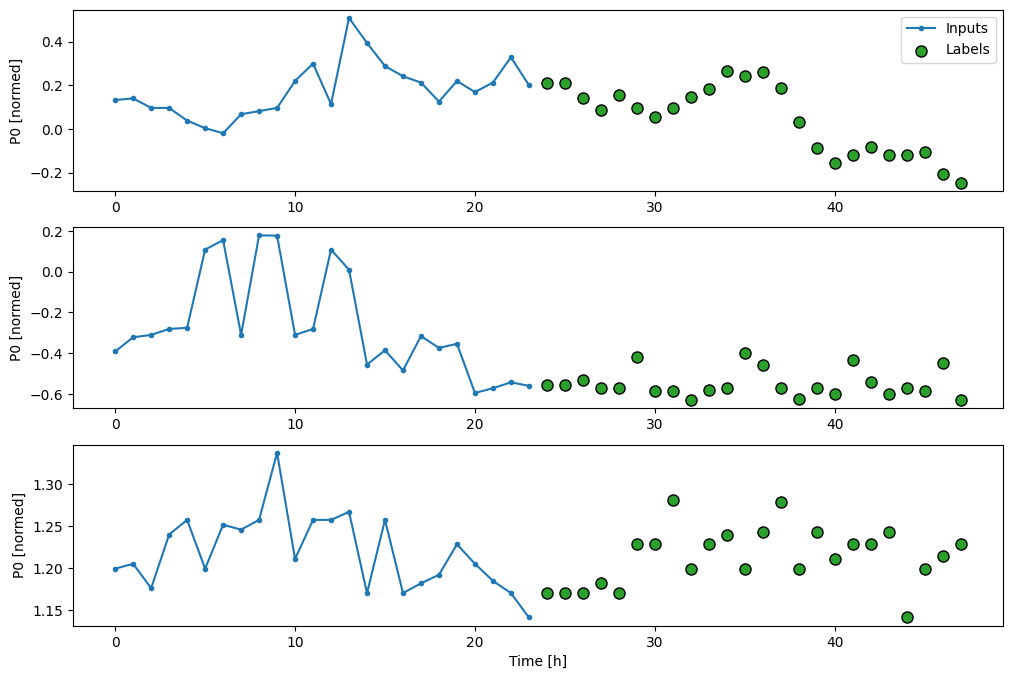

In [191]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df_p0,
                               val_df=val_df_p0,
                               test_df=test_df_p0)

multi_window.plot()
multi_window

8293/8293 [==============================] - 11s 1ms/step - loss: 0.1000 - mean_absolute_error: 0.1509


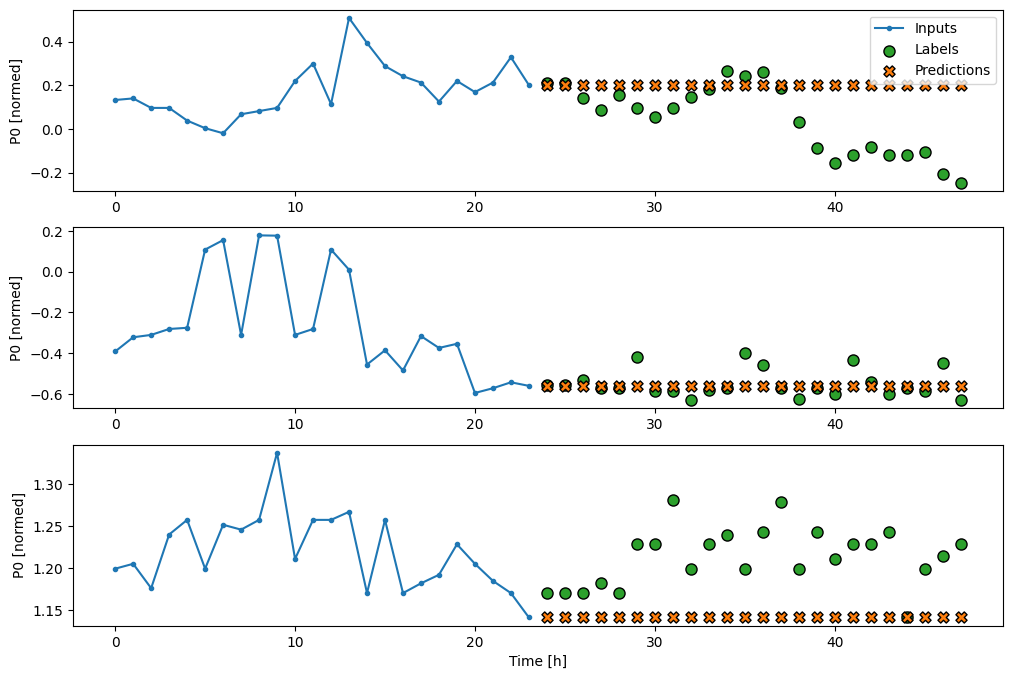

In [192]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

8293/8293 [==============================] - 11s 1ms/step - loss: 0.2015 - mean_absolute_error: 0.2492


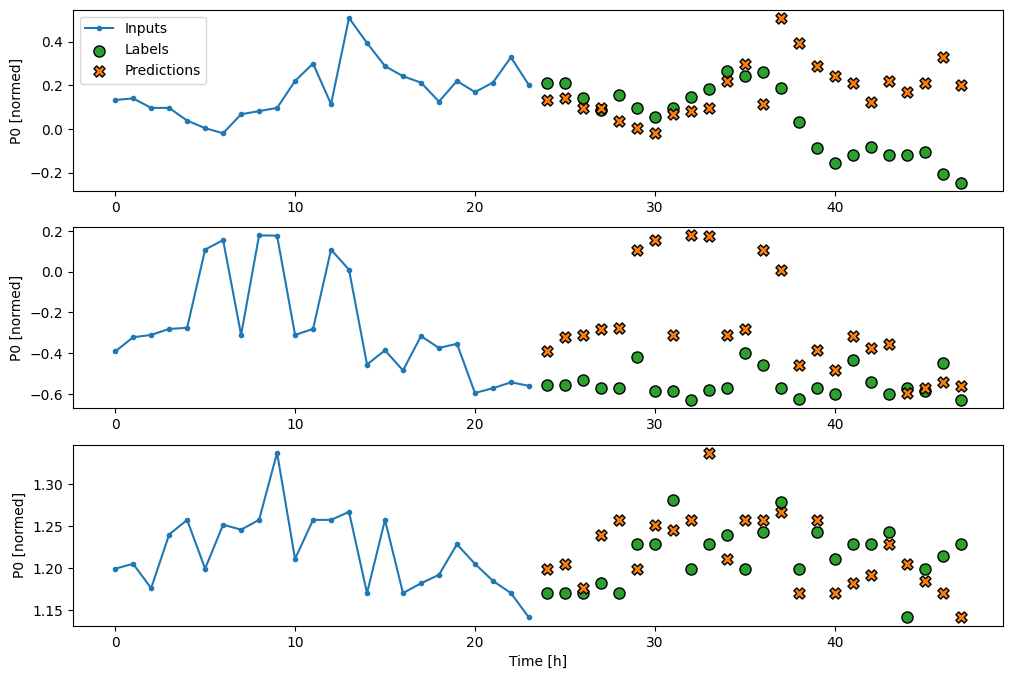

In [193]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

8293/8293 [==============================] - 11s 1ms/step - loss: 0.0812 - mean_absolute_error: 0.1339


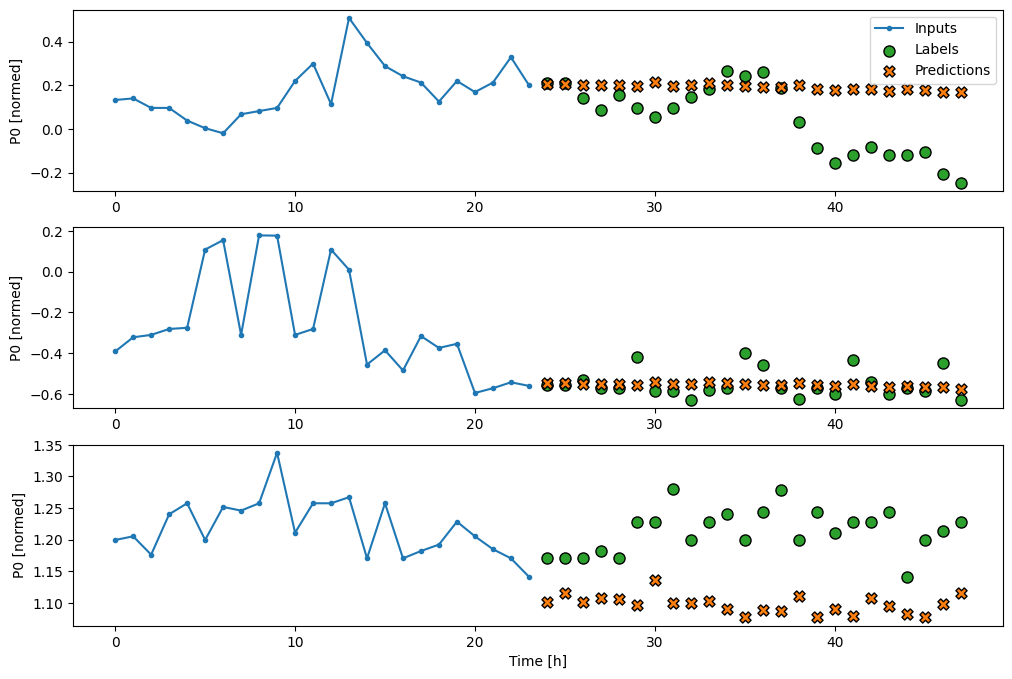

In [195]:
num_features = 5
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

8293/8293 [==============================] - 13s 2ms/step - loss: 0.0756 - mean_absolute_error: 0.1269


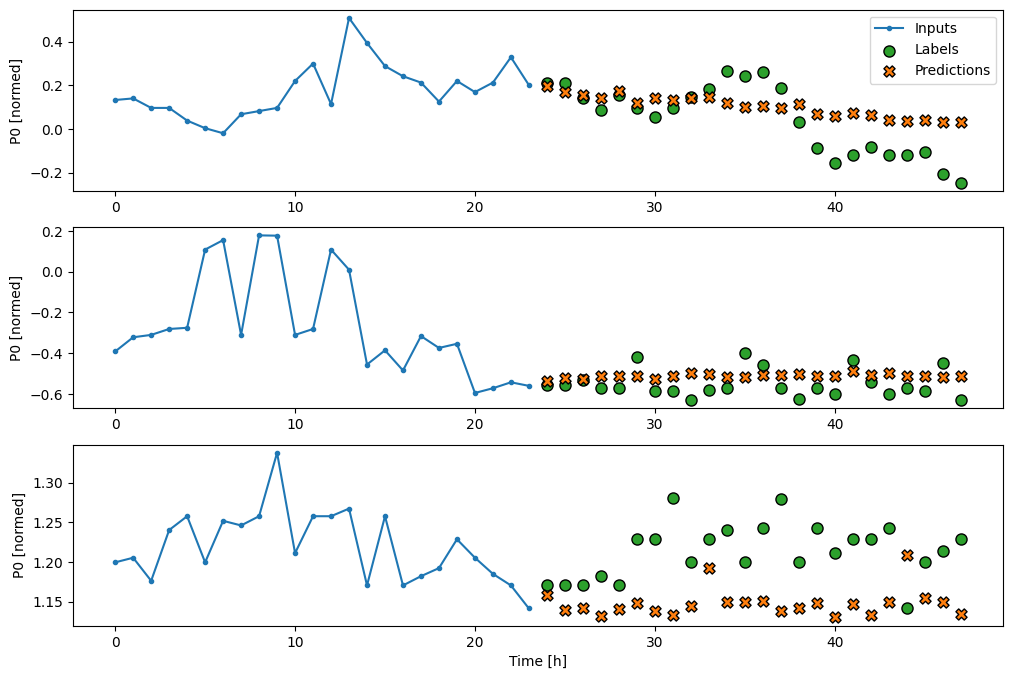

In [196]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

8293/8293 [==============================] - 32s 4ms/step - loss: 0.0633 - mean_absolute_error: 0.1088


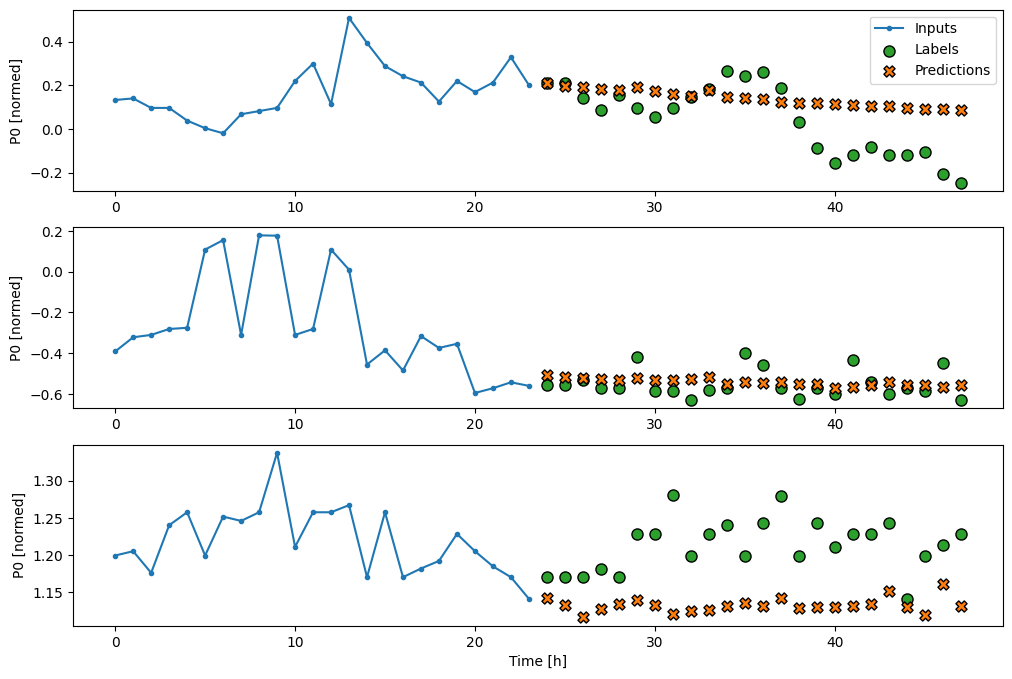

In [197]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
# metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = multi_val_performance.values()
test_mae = multi_performance.values()
print(test_mae)

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()